In [1]:
"""Hospital Bed Management"""
"""Can we predict hospital bed availability based on patient demand, staff morale, 
and weekly hospital activity?”"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge


In [2]:
pd.set_option("display.max_columns", 1000)

# ------------------ Data Loading ------------------
set3 = pd.read_csv(r"C:\Users\Amirhamza\OneDrive\Desktop\Hospital  Beds Management\staff.csv")
set4 = pd.read_csv(r"C:\Users\Amirhamza\OneDrive\Desktop\Hospital  Beds Management\staff_schedule.csv")
set2 = pd.read_csv(r"C:\Users\Amirhamza\OneDrive\Desktop\Hospital  Beds Management\services_weekly.csv")
set1 = pd.read_csv(r"C:\Users\Amirhamza\OneDrive\Desktop\Hospital  Beds Management\patients.csv")


In [3]:
# ------------------ Data Merging ------------------
merged = pd.merge(
    set4, set3,
    on=['staff_id', 'staff_name', 'role', 'service'],
    how='left'
)
print(merged.info())
merged1 = pd.merge(
    merged, set2,
    on=['service', 'week'],
    how='left'
)
print(merged1.info())

set1_agg = set1.groupby('service').agg({
    'satisfaction': 'mean',
    'age': 'mean',
    'patient_id': 'count'
}).reset_index()

# Rename columns
set1_agg.rename(columns={
    'satisfaction': 'avg_patient_satisfaction',
    'age': 'avg_patient_age',
    'patient_id': 'total_patients'
}, inplace=True)

# Final merge
ds = pd.merge(
    merged1, set1_agg,
    on='service',
    how='left'
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6552 entries, 0 to 6551
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   week        6552 non-null   int64 
 1   staff_id    6552 non-null   object
 2   staff_name  6552 non-null   object
 3   role        6552 non-null   object
 4   service     6552 non-null   object
 5   present     6552 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 307.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6552 entries, 0 to 6551
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   week                  6552 non-null   int64 
 1   staff_id              6552 non-null   object
 2   staff_name            6552 non-null   object
 3   role                  6552 non-null   object
 4   service               6552 non-null   object
 5   present               6552 non-null   int64 
 6   month

In [4]:
# ------------------ Encoding ------------------
le = LabelEncoder()
ds['service_encoded'] = le.fit_transform(ds['service'])
ds['event_encoded'] = le.fit_transform(ds['event'])
ds['role_encoded'] = le.fit_transform(ds['role'])

ds.drop(columns=['service', 'event', 'role', 'staff_name'], inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6552 entries, 0 to 6551
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   week                      6552 non-null   int64  
 1   staff_id                  6552 non-null   object 
 2   present                   6552 non-null   int64  
 3   month                     6552 non-null   int64  
 4   available_beds            6552 non-null   int64  
 5   patients_request          6552 non-null   int64  
 6   patients_admitted         6552 non-null   int64  
 7   patients_refused          6552 non-null   int64  
 8   patient_satisfaction      6552 non-null   int64  
 9   staff_morale              6552 non-null   int64  
 10  avg_patient_satisfaction  6552 non-null   float64
 11  avg_patient_age           6552 non-null   float64
 12  total_patients            6552 non-null   int64  
 13  service_encoded           6552 non-null   int32  
 14  event_en

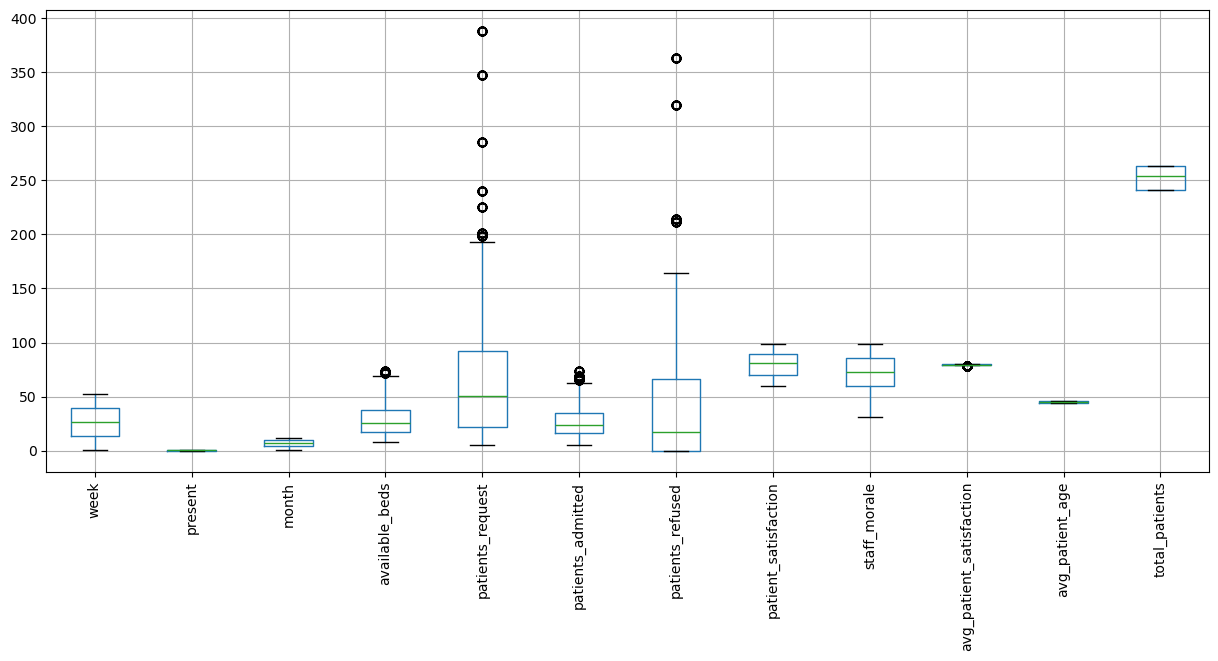

In [5]:
# ------------------ EDA ------------------
print(ds.info())
print(ds.isnull().sum())

ds.select_dtypes(include=['float64', 'int64']).boxplot(figsize=(15, 6))
plt.xticks(rotation=90)
plt.show()


In [6]:
# ------------------ Feature Selection ------------------
x = ds.drop(columns=['staff_id', 'available_beds'])
x1 = ds.drop(columns=['staff_id', 'available_beds', 'role_encoded', 'event_encoded',
                      'service_encoded', 'total_patients', 'staff_morale',
                      'patient_satisfaction', 'patients_refused', 'present'])
y = ds['available_beds']

# ✅ FIXED HERE: using x1 for training
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=42)


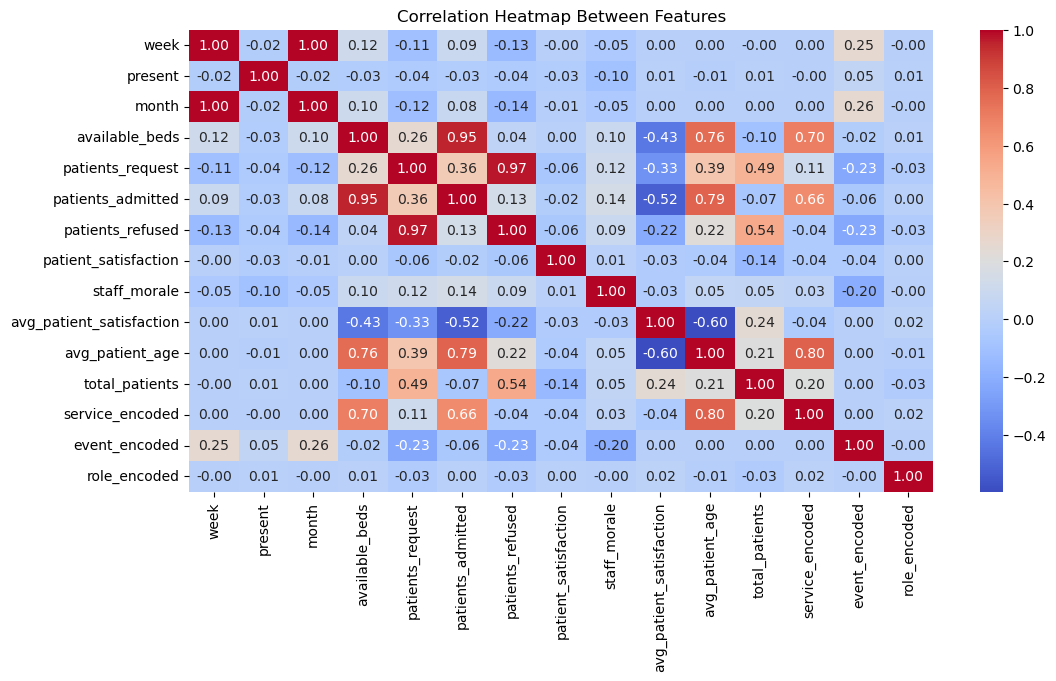

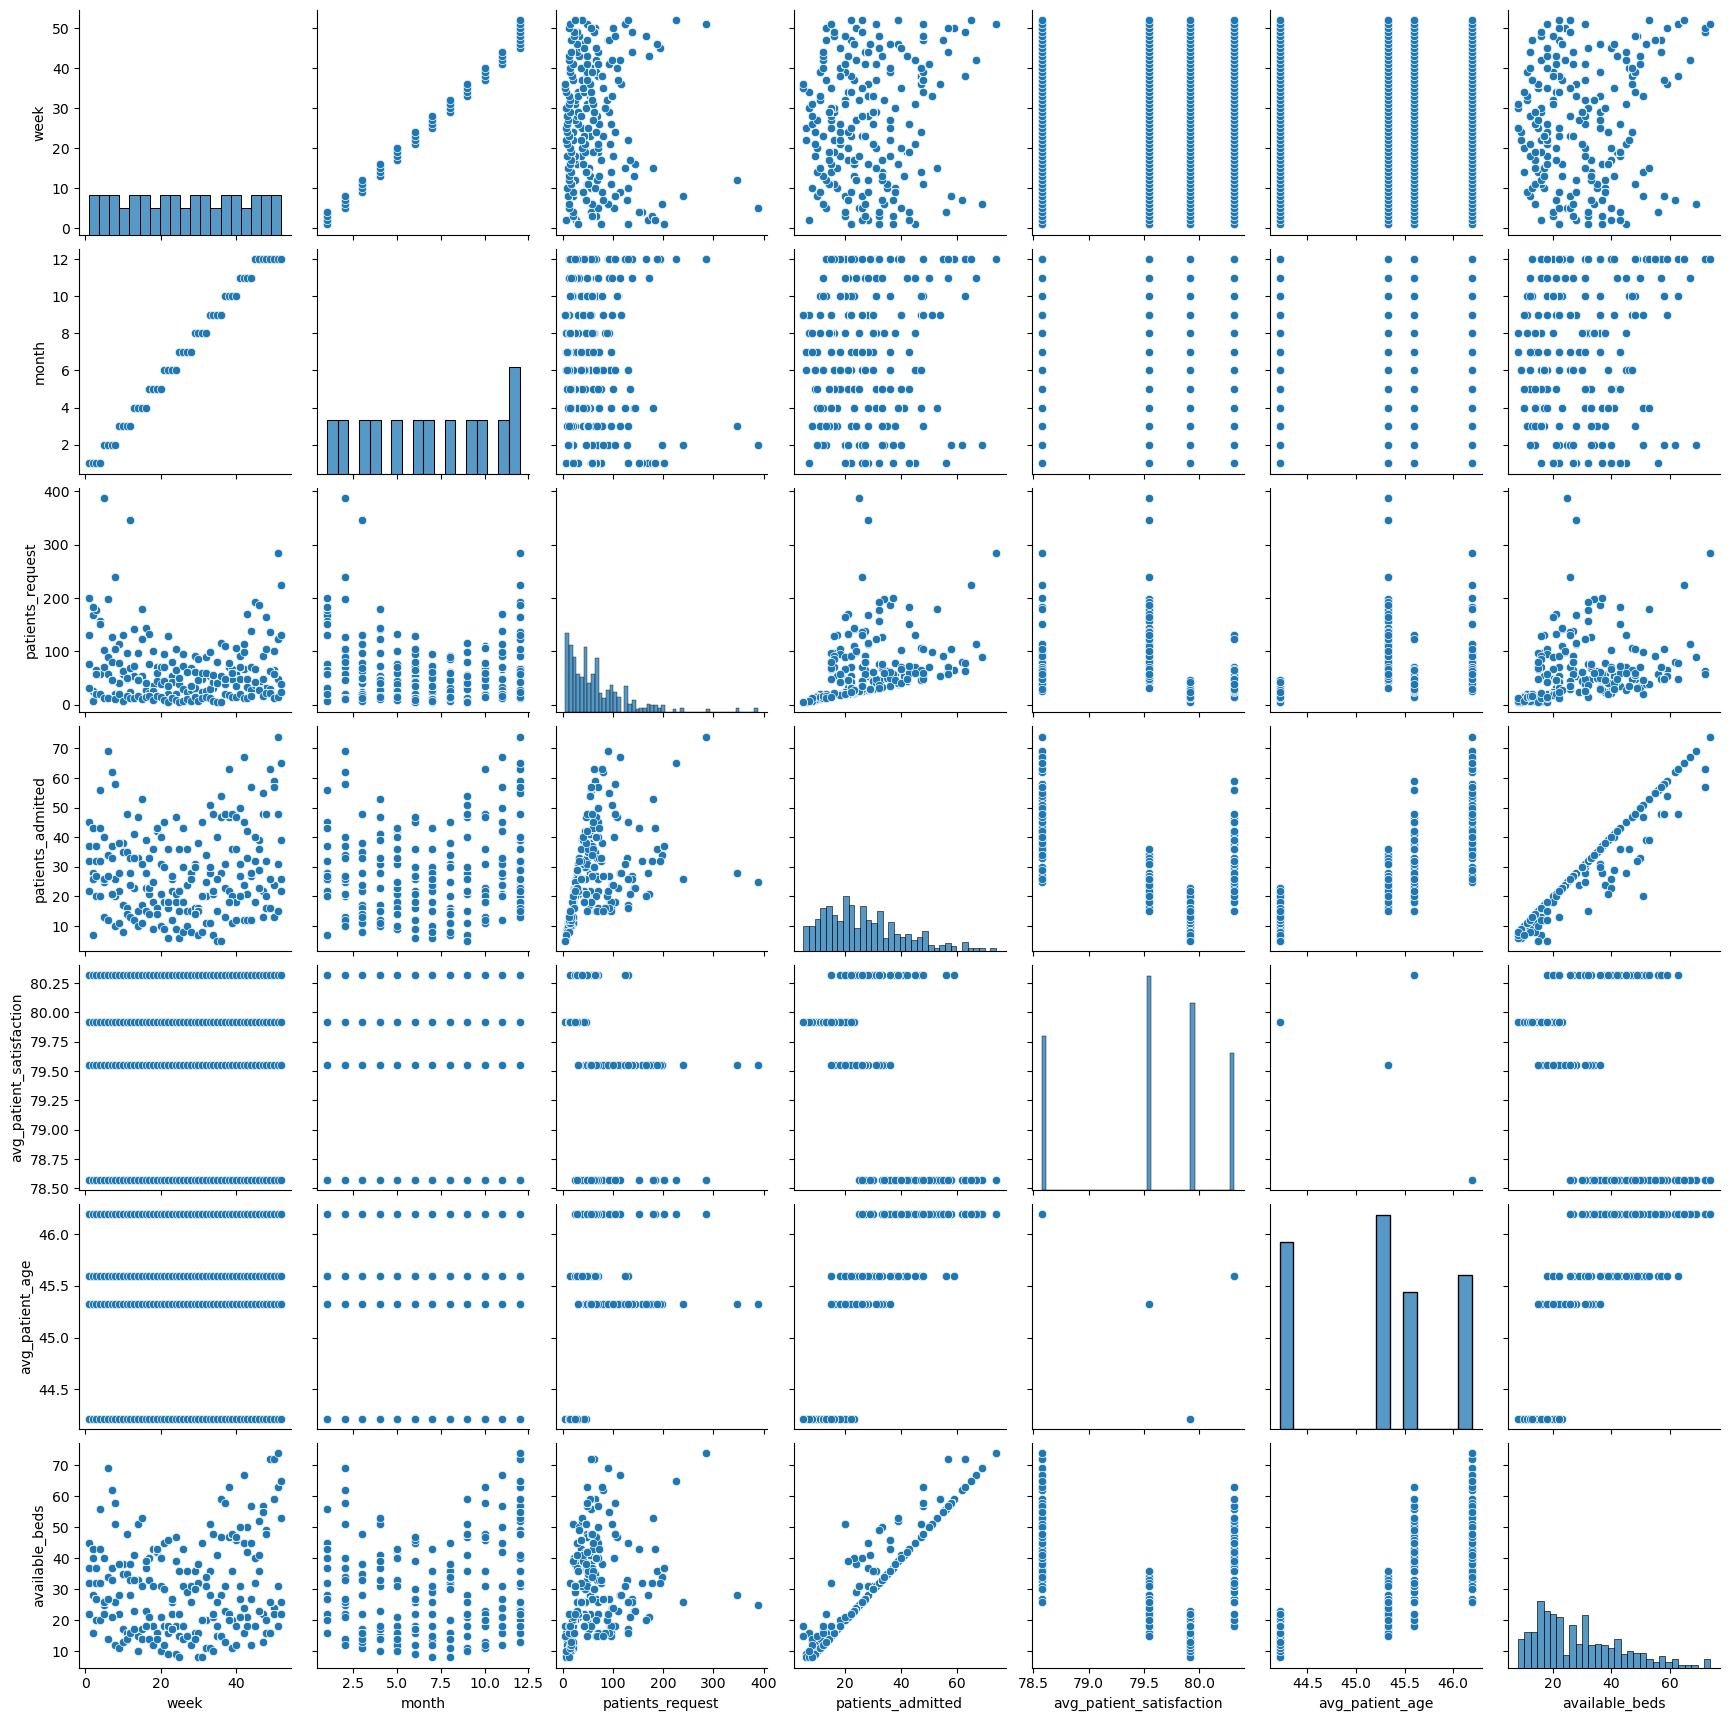

In [7]:
# ------------------ Visualization ------------------
plt.figure(figsize=(12, 6))
sns.heatmap(ds.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap Between Features")
plt.show()

x2 = pd.concat([x1, y], axis=1)
sns.pairplot(x2)
plt.show()


In [8]:
# ------------------ Model Training ------------------
lr = LinearRegression()
lr.fit(x1_train, y_train)
print("Linear Regression:", lr.score(x1_test, y_test), lr.score(x1_train, y_train))

lr1 = Lasso()
lr1.fit(x1_train, y_train)
print("Lasso Regression:", lr1.score(x1_test, y_test), lr1.score(x1_train, y_train))


Linear Regression: 0.9301247191490031 0.9278548037695907
Lasso Regression: 0.9199508469896278 0.9203792414234899


In [9]:
# ------------------ Predictions ------------------
ds["Predicted_Bed_Availability"] = lr1.predict(x1)
result = ds[['week', 'available_beds', 'Predicted_Bed_Availability']]
print(result.head(100))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = lr1.predict(x1_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))



    week  available_beds  Predicted_Bed_Availability
0      1              32                   33.501462
1      2              28                   27.391326
2      3              32                   31.283388
3      4              32                   31.741181
4      5              25                   19.521642
..   ...             ...                         ...
95    44              27                   27.624844
96    45              32                   31.486492
97    46              36                   35.689698
98    47              22                   23.638608
99    48              20                   19.979017

[100 rows x 3 columns]
MAE: 2.747071499124264
RMSE: 4.252771032091272
R² Score: 0.9199508469896278


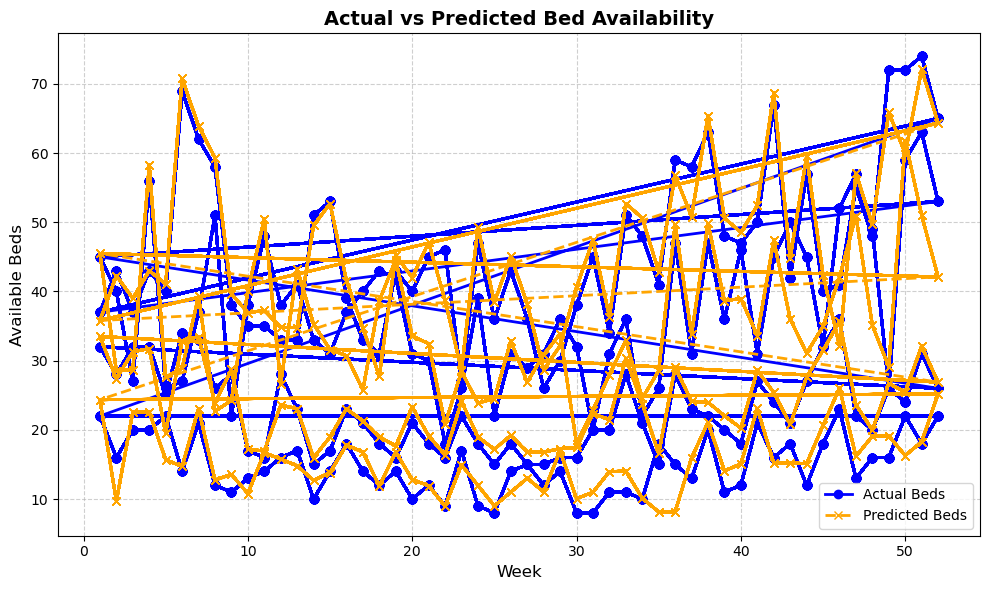

In [10]:
# ------------------ Visualization ------------------
plt.figure(figsize=(10, 6))
plt.plot(result['week'], result['available_beds'], label='Actual Beds', color='blue', linewidth=2, marker='o')
plt.plot(result['week'], result['Predicted_Bed_Availability'], label='Predicted Beds', color='orange', linewidth=2, linestyle='--', marker='x')
plt.title("Actual vs Predicted Bed Availability", fontsize=14, weight='bold')
plt.xlabel("Week", fontsize=12)
plt.ylabel("Available Beds", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


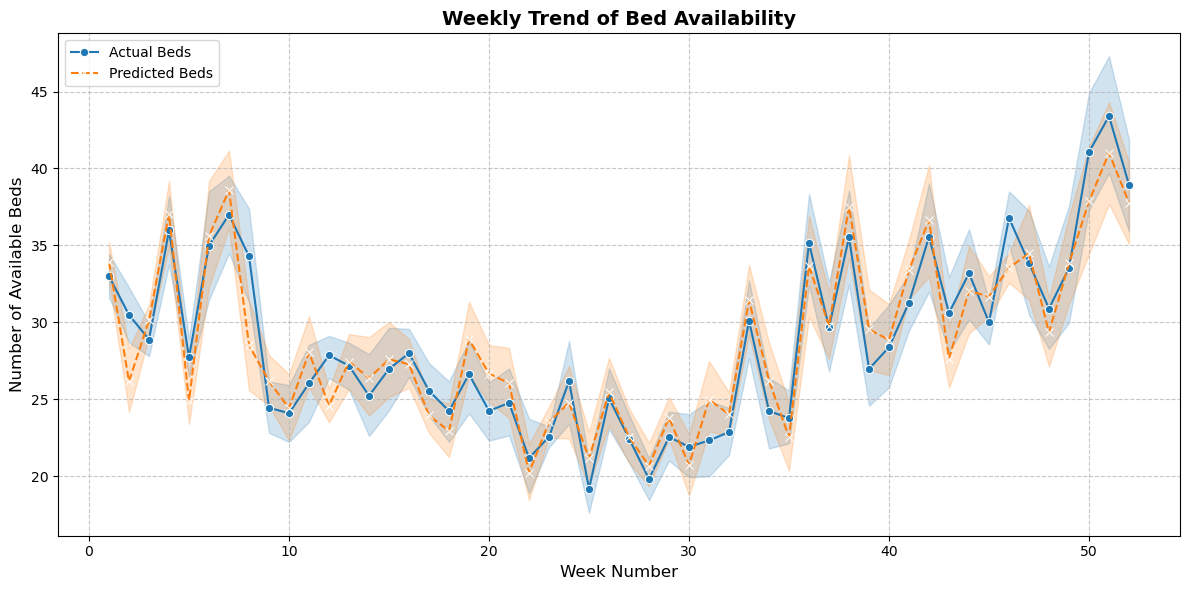

In [11]:
# ------------------ Time Trend Visualization ------------------

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='available_beds', data=ds, label='Actual Beds', marker='o')
sns.lineplot(x='week', y='Predicted_Bed_Availability', data=ds, label='Predicted Beds', marker='x', linestyle='--')

plt.title("Weekly Trend of Bed Availability", fontsize=14, weight='bold')
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Number of Available Beds", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
# ------------------ User Input for New Prediction ------------------
print("\nAvailable input columns for prediction:")
print(list(x1.columns))

print("\n----- Enter details for new prediction -----")
week = int(input("Enter week number: "))
month = int(input("Enter month number: "))
patients_request = float(input("Enter number of patients requested: "))
patients_admitted = float(input("Enter number of patients admitted: "))
avg_patient_satisfaction = float(input("Enter average patient satisfaction (%): "))
avg_patient_age = float(input("Enter average patient age: "))

# Create dataframe for prediction
new_data = pd.DataFrame({
    'week': [week],
    'month': [month],
    'patients_request': [patients_request],
    'patients_admitted': [patients_admitted],
    'avg_patient_satisfaction': [avg_patient_satisfaction],
    'avg_patient_age': [avg_patient_age]
})

# Predict using trained Lasso model
predicted_beds = lr1.predict(new_data)
predicted_round_beds=round(predicted_beds[0])
print(f"\n✅ Predicted Available Beds: {predicted_round_beds}")



Available input columns for prediction:
['week', 'month', 'patients_request', 'patients_admitted', 'avg_patient_satisfaction', 'avg_patient_age']

----- Enter details for new prediction -----


Enter week number:  6
Enter month number:  2
Enter number of patients requested:  89
Enter number of patients admitted:  69
Enter average patient satisfaction (%):  75
Enter average patient age:  45



✅ Predicted Available Beds: 71
